# Visualization and segmentation for merfish data
Thomas Defard 05/05/2024

In [1]:
import sys
sys.path = ['', '/home/tom/anaconda3/envs/autofish_analysis/lib/python38.zip', '/home/tom/anaconda3/envs/autofish_analysis/lib/python3.8', '/home/tom/anaconda3/envs/autofish_analysis/lib/python3.8/lib-dynload', '/home/tom/.local/lib/python3.8/site-packages', '/home/tom/Bureau/phd/st_seg/ssam_merfish/ssam_pkg', '/home/tom/anaconda3/envs/autofish_analysis/lib/python3.8/site-packages']

In [2]:
import pandas as pd 
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import tifffile
import matplotlib.pyplot as plt
import squidpy as sq
import anndata as ad
import scanpy as sc
import scanpy
import torch
from cellpose import models 


/home/tom/anaconda3/envs/autofish_analysis/lib/python3.8/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/home/tom/anaconda3/lib/python3.8/site-packages), Requirement.parse('numpy<1.21,>=1.17'), {'numba'}))'.
  numba.core.entrypoints.init_all()


**To install a package do ``pip install name_of_package `` in your terminal**

best practice  :  use a conda environnement https://conda.io/projects/conda/en/latest/user-guide/getting-started.html  

To use a conda env in a notebook apply this tutorial : https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

# visualization of the entire slide


You can visualize you data with TissUUmaps (https://tissuumaps.github.io/installation/ ), a software design for very large image
Once it is install, do ``$ tissuumaps`` in your terminal and you can drop images in it and you get this images : 

<img src="img_notebook/all_tissue.png" alt="drawing" width="50%"/>

To vizualise the RNA spots you can drop ``detected_transcript.csv`` in tissuumaps but the rna spots are not alligned with the images so you will get an images like below. 
Also, the spot coordiantes are in µm and not in pixel. You have to put 1/0.108 = 9.259 in the "scale" option to get it in pixel.

You can aslo vizualised the position of the cell detected by MERSPCOPE with the file ``cell_metadata.csv``

<img src="img_notebook/spots1.png" alt="drawing" width="50%"/>

To register the spots with this images you have to use the "manifest.json" file 

In [3]:
##### TO COMPLETE WITH YOUR PATH

path_to_region = "/media/tom/Transcend/chenxi/region_1"
path_to_save_csv_rna = path_to_region + "/rna_z_stack1"

# create the folder to save the registered CSV
Path(path_to_save_csv_rna).mkdir(parents=True, exist_ok=True)

In [13]:

f = open(path_to_region + "/images/manifest.json")
manifest = json.load(f)

x_off_set_microns = manifest['bbox_microns'][0]
y_off_set_microns = manifest['bbox_microns'][1]

### register the csv
csv = pd.read_csv(path_to_region + "/detected_transcripts.csv")
csv["global_x"] = csv["global_x"] - x_off_set_microns
csv["global_y"] = csv["global_y"] - y_off_set_microns


# SAVE the csv
for z in tqdm(np.unique(csv["global_z"])):
    csv_z = csv[csv["global_z"] == z]
    print(csv_z.shape)
    csv_z.to_csv(Path(path_to_save_csv_rna) / f"z_{z}.csv", index=False)

csv.to_csv(Path(path_to_save_csv_rna) / f"all_z.csv", index=False)


# save registered cell_metadata
csv_cell = pd.read_csv(path_to_region + "/cell_metadata.csv")
csv_cell["center_x"] = csv_cell["center_x"] - x_off_set_microns
csv_cell["center_y"] = csv_cell["center_y"] - y_off_set_microns
csv_cell.to_csv(Path(path_to_save_csv_rna) / f"cell_metadata.csv", index=False)


  0%|                                                                                                                                                                                                             | 0/7 [00:00<?, ?it/s]

(1562364, 11)


 14%|████████████████████████████▏                                                                                                                                                                        | 1/7 [00:08<00:48,  8.12s/it]

(1745837, 11)


 29%|████████████████████████████████████████████████████████▎                                                                                                                                            | 2/7 [00:17<00:43,  8.63s/it]

(1928940, 11)


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 3/7 [00:27<00:37,  9.26s/it]

(2011165, 11)


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 4/7 [00:37<00:29,  9.73s/it]

(1964229, 11)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 5/7 [00:47<00:19,  9.86s/it]

(1785891, 11)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 6/7 [00:56<00:09,  9.62s/it]

(1569245, 11)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:04<00:00,  9.25s/it]


Then you can drop in ``tissUUMap`` the new csv  files you just saved in ``path_to_save_csv_rna``

<img src="img_notebook/spots_registered.png" alt="drawing" width="50%"/>

## Manually select a regions of interest (ROI) to test segmentation 
To test segmentation with cellpose or other algoritm. It is better to select a small ROI like one embrio.
I just do it manually 

In [4]:
## PATH 
## create a folder to save the result
path_to_save_crop = path_to_region + "/crop2"
Path(path_to_save_crop).mkdir(parents=True, exist_ok=True)
path_to_save_crop_csv = path_to_save_crop + "/csv"
Path(path_to_save_crop_csv).mkdir(parents=True, exist_ok=True)
path_to_save_crop_img = path_to_save_crop + "/images"
Path(path_to_save_crop_img).mkdir(parents=True, exist_ok=True)

Plot the entire image first to know where to crop

In [20]:
Cellbound2 = tifffile.imread(path_to_region + "/images/mosaic_DAPI_z4.tif")

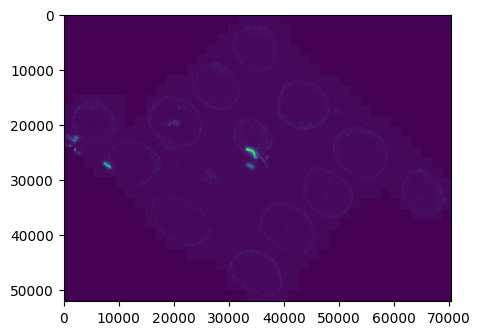

In [11]:
## Vizualise the whole slide so you choose the embrio you want to study, this step take can take few minutes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Cellbound2)
plt.show()


In [23]:
### select the coordinates of the ROI you want
crop_min_x = 18500
crop_max_x = 28500
crop_min_y = 4800
crop_max_y = 13950

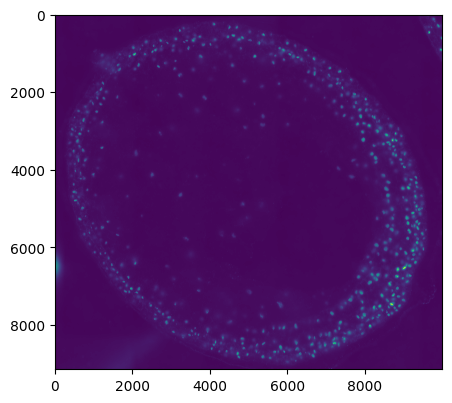

In [24]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(Cellbound2[crop_min_y:crop_max_y,crop_min_x:crop_max_x])
plt.show()

In [25]:
#### save the cropped images
path_tiff_folder = Path(path_to_region + "/images")
for path_tiff in tqdm(list(path_tiff_folder.glob("*_z4.tif"))):
    try : 
        tiff = tifffile.imread(path_tiff)
        tifffile.imwrite(Path(path_to_save_crop_img) / path_tiff.name, tiff[crop_min_y:crop_max_y,crop_min_x:crop_max_x])
    except Exception as e:
        print(e)
        print(f"{path_tiff.name} where not save")
        pass


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.96s/it]


### Save the cropped ROI with the corresponding RNA and cell coordinates csv


In [25]:
## PATH AND VARIAble
limx = crop_max_x - crop_min_x
limy =  crop_max_y - crop_min_y
pixel_size = 0.108
x_key = "global_x"
y_key = "global_y"

In [ ]:
# save the cropped ROI with the corresponding RNA and cell coordinates csv


for path_csv  in tqdm(list(Path(path_to_save_csv_rna).glob("*z*.csv"))):
    csv = pd.read_csv(path_csv)
    print(csv.shape)
    csv[x_key] = csv[x_key] - crop_min_x * pixel_size
    csv[y_key] = csv[y_key] - crop_min_y * pixel_size
    csv = csv[np.logical_and(np.logical_and(csv[x_key] > 0, csv[y_key] > 0),
                             np.logical_and(csv[x_key] < limx * pixel_size, csv[y_key] < limy * pixel_size))]

    print(csv.shape)
    print()
    csv.to_csv(Path(path_to_save_crop_csv) / path_csv.name, index=False)

## save cropped cell_metadata
csv_cell = pd.read_csv(path_to_save_csv_rna + "/cell_metadata.csv")
csv_cell["center_x"] = csv_cell["center_x"] - crop_min_x
csv_cell["center_y"] = csv_cell["center_y"] - crop_min_y
csv_cell.to_csv(Path(path_to_save_crop_csv) / f"cell_metadata.csv", index=False)


## Test segmentation
you can test if segmentation works with a default pre-trained netwok, if this step is too long you can run test only on tiles images (next step)

The segmentation is performed with cellpose, you can try many different parameters : https://cellpose.readthedocs.io/en/latest/settings.html

In [8]:
## PATH 


USE_GPU = torch.cuda.is_available()
print(USE_GPU)
path_to_save_segmentation = path_to_save_crop + "/segmentation"

False


/home/tom/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
## this step can take a mintute if USE_GPU is true, about 5 to 10 minute otherwise
## if the image is to large for your computer, use USE_GPU = False
model = models.CellposeModel(gpu=False,
                             model_type='cyto')

print(model.gpu)

im = tifffile.imread(path_to_save_crop_img + "/mosaic_Cellbound3_z4.tif")

masks, flows, styles = model.eval(im,
                                     diameter=90,
                                     channels=[0, 0],
                                     flow_threshold=0.4,
                                     do_3D=False,
                                     stitch_threshold=0)

Path(path_to_save_segmentation).mkdir(parents=True, exist_ok=True)

tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation.tif", data=masks, dtype=masks.dtype)
tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation_binary.tif", data=np.array(masks > 0).astype(masks.dtype) , dtype=masks.dtype)

False


Use ``segmentation_binary.tif`` to vizualised it in the tissuumap

<img src="img_notebook/seg1.png" alt="drawing" width="50%"/>

## Annotate few tiles to retrain the model.
To improve the perfomance of the model, you need to annotate some cells yourself on few tiles so the model can be'retrained' on these good examples  

the first step is crop some tiles (small images) so you can annotate in the cellpose graphical user interface (GUI)

In [46]:
##crop some tiles

### load the Z stack / cellbound you want to tile
im = tifffile.imread(path_to_save_crop_img + "/mosaic_Cellbound3_z4.tif")

## set the tilling dimmension, here a 10x10 grid
M = im.shape[0] // 10
N = im.shape[1] // 10

tiles = [{str(x)+'_'+str(y) :  im[x:x + M, y:y + N]} for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)]

## save the tiles for latter used
path_to_save_crop_tiles = path_to_save_crop_img + '/mosaic_Cellbound3_z4'
Path(path_to_save_crop_tiles).mkdir(parents=True, exist_ok=True)

for t in tiles:
    for k in t:
        tifffile.imwrite(Path(path_to_save_crop_tiles) / (k +'.tif'), t[k])
        

Then you can use the cellpose GUI to annotate and re-train your model.  
If not already, install cellpose GUI by doing ``python -m pip install cellpose[gui]`` in a terminal

lunch it with ``python -m cellpose`` in a terminal and follow the guideline here: https://cellpose.readthedocs.io/en/latest/gui.html

<img src="img_notebook/annotation.png" alt="drawing" width="50%"/>

## Re-apply the segmentation
Once the result are good in the gui, you can re-apply the re-trained cellpose on your cropped ROI.
The re-trained model is a file in the tiles folder. You need to complete the argument ``pretrained_model``  
Of note it is better to use the `` diameter`` used for the training and do not use a too small diameter for memory issue.

In [ ]:
USE_GPU =False
## to complete with your path 
pretrained_model = "/media/tom/Transcend/bioinfo-portal.curie.fr/backend/services/popeye/2018383/output/region_1/crop2/images/mosaic_Cellbound3_z4/models/CP_chenxi"
model = models.CellposeModel(gpu=USE_GPU,
                             
                             pretrained_model = pretrained_model)

print(model.gpu)
                    #    pretrained_model='/media/tom/Transcend/bioinfo-portal.curie.fr/backend/services/popeye/2018383/output/region_1/crop_7200_18000_37500_48500/retraining_DAPI/models/TN2_DAPIeee')
im = tifffile.imread(path_to_save_crop_img + "/mosaic_Cellbound3_z4.tif")

masks, flows, styles = model.eval(im,
                                     diameter=118,
                                     channels=[0, 0],
                                     flow_threshold=0.4,
                                     stitch_threshold=0)

path_to_save_segmentation = path_to_save_crop + "/segmentation"
Path(path_to_save_segmentation).mkdir(parents=True, exist_ok=True)

tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation_retrained.tif", data=masks, dtype=masks.dtype)
tifffile.imwrite(Path(path_to_save_segmentation) / "segmentation_retrained_binary.tif", data=np.array(masks > 0).astype(masks.dtype) , dtype=masks.dtype)

### Cellpose with both cellbound and dapi as input 
this model as to be pretrained with the two channel in th cellpose GUI, for this you need to preprocess tiles with two channels [ cellbound, dapi] for the input

In [56]:

## set channel name
chanel1 = "mosaic_Cellbound2_z4"
chanel2 = "mosaic_DAPI_z4"


### load the Z stack / cellbound you want to tile
im1 = tifffile.imread(path_to_save_crop_img + f"/{chanel1}.tif")
im2 = tifffile.imread(path_to_save_crop_img + f"/{chanel2}.tif")

## set the tilling dimmension, here a 10x10 grid
M = im1.shape[0] // 10
N = im1.shape[1] // 10

im = np.array([im1, im2])

tiles = [{str(x)+'_'+str(y) :  im[:, x:x + M, y:y + N]} for x in range(0,im1.shape[0], M) 
         for y in range(0, im1.shape[1], N)]

## save the tiles for latter used
path_to_save_crop_tiles = path_to_save_crop_img + '/cellbound2_dapi'
Path(path_to_save_crop_tiles).mkdir(parents=True, exist_ok=True)

for t in tiles:
    for k in t:
        tifffile.imwrite(Path(path_to_save_crop_tiles) / (k +'.tif'), t[k])
        

## Generate a count matrix from the segmentation

##### 1) update csv files 

In [26]:
### LOAD THE SEGMENTATION MASK
#path_to_save_segmentation = "/media/tom/Transcend1/chenxi/region_1/crop2/segmentation"

seg_cell_mask = tifffile.imread(Path(path_to_save_segmentation) / "segmentation_retrained.tif")

#path_to_save_crop_csv = "/media/tom/Transcend1/chenxi/region_1/crop2/csv/"
## load the spots coodinate 
csv = pd.read_csv(Path(path_to_save_crop_csv)  / "all_z.csv")

list_cell = []
list_y = list(csv.global_y / pixel_size)
list_x = list(csv.global_x / pixel_size)

for index in range(len(list_y)):
    list_cell.append(seg_cell_mask[int(list_y[index]), int(list_x[index])])
    
csv["cell"] = list_cell


##### 2) save the anndata with scanpy 

In [5]:
unique_cell  = np.unique(list_cell)

list_cell_pred = np.array(list_cell)
list_df_gene = np.array(csv.gene)

selected_genes = np.unique(list_df_gene)
gene_index_dico = {}
for gene_id in range(len(selected_genes)):
    gene_index_dico[selected_genes[gene_id]] = gene_id

    
count_matrix = []
for nucleus in tqdm(unique_cell):
    if nucleus == 0:
        continue
    list_gene = list_df_gene[list_cell_pred == nucleus]
    expression_vector = np.zeros(len(selected_genes))
    for str_gene in list_gene:
        expression_vector[gene_index_dico[str_gene]] += 1
    count_matrix.append(expression_vector)



adata = ad.AnnData(np.array(count_matrix))
adata.var["features"] = selected_genes
adata.obs["cells_id"] = unique_cell[1:]
adata.var_names = selected_genes
adata.write(Path(path_to_save_segmentation).parent / f"anndata.h5ad")

NameError: name 'list_cell' is not defined

##### 3) example of annadata usage (clustering)

In [6]:
def cluster(adata,
            n_neighbors = 30,
            n_pcs = 30,
            resolution = 1.0):

    ## normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    ## compute pca
    sc.tl.pca(adata, svd_solver='arpack', n_comps=n_pcs)
    ## compute neighbors
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    ## compute leiden
    sc.tl.leiden(adata, resolution=resolution)
    sc.tl.umap(adata)

    fig  = sc.pl.umap(adata, color=["leiden"], legend_loc='on data', return_fig=True, title = '')
    plt.title('')
    plt.show()
    ## save the figure

    return fig


In [9]:
adata = sc.read_h5ad(Path(path_to_save_segmentation).parent / f"anndata.h5ad")
adata

AnnData object with n_obs × n_vars = 468 × 180
    obs: 'cells_id'
    var: 'features'

2024-05-06 15:24:25.773621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 15:24:26.580216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/tom/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


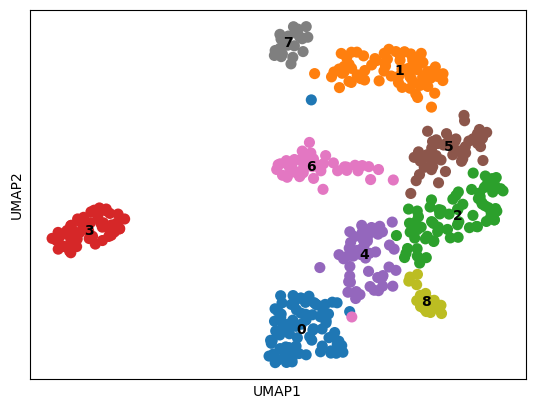

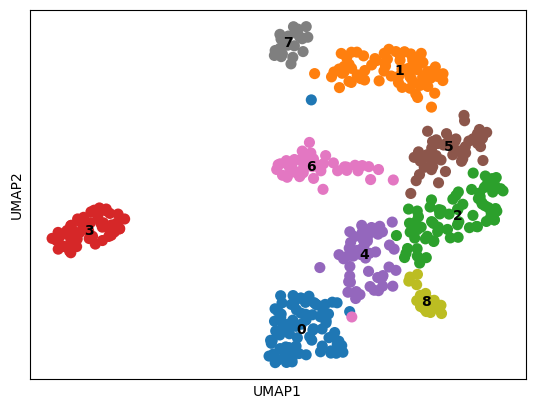

In [10]:
adata  = scanpy.read(Path(path_to_save_segmentation).parent / f"anndata.h5ad")
cluster(adata,
            n_neighbors = 30,
            n_pcs = 30,
            resolution = 1.0)

##### the function cluster() adds information like "leiden" clustering ect....

In [11]:
adata

AnnData object with n_obs × n_vars = 468 × 180
    obs: 'cells_id', 'leiden'
    var: 'features'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## compute cell centroid 

In [12]:
from skimage.measure import regionprops

def compute_centroids(seg_cell_mask):
    properties = regionprops(seg_cell_mask)
    dict_centroids = {prop.label : prop.centroid for prop in properties if prop.label!=0}
    return dict_centroids

In [13]:

## load the corresponding data

seg_cell_mask = tifffile.imread(Path(path_to_save_segmentation) / "segmentation_retrained.tif")

## compute the centroid
dict_centroids = compute_centroids((seg_cell_mask))

## add centroid to anndata
list_centroid_x = [ dict_centroids[cell][1] for cell in  adata.obs['cells_id']]
list_centroid_y = [ dict_centroids[cell][0] for cell in  adata.obs['cells_id']]
adata.obs['Centroid_X'] = list_centroid_x
adata.obs['Centroid_Y'] = list_centroid_y

## VIZUALIZATION 

possible tutorial : 
- https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_merfish.html
- https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_vizgen.html
- https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/index.html  

Or using spatial ID : 
- https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks.html


In the tutorial they require to put the centroid infeomtion in adata.obsm["spatial"]

In [27]:
spatial = np.array([np.array(list_centroid_y), np.array(list_centroid_x)]).T
spatial.shape

(468, 2)

In [28]:
adata.obsm["spatial"] = spatial

/home/tom/anaconda3/envs/autofish_analysis/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


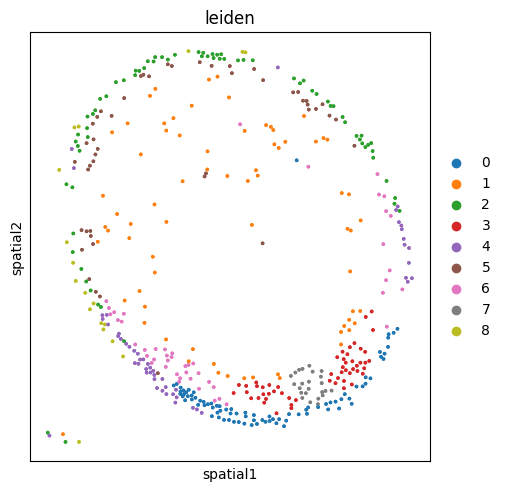

In [26]:
sq.pl.spatial_scatter(
    adata, shape=None, color="leiden", size=10
)

# CHECK Y AND X are not inversed  !!

In [30]:
#### Now you can compute many analysis like neigborhood statistic

  0%|          | 0/1000 [00:00<?, ?/s]

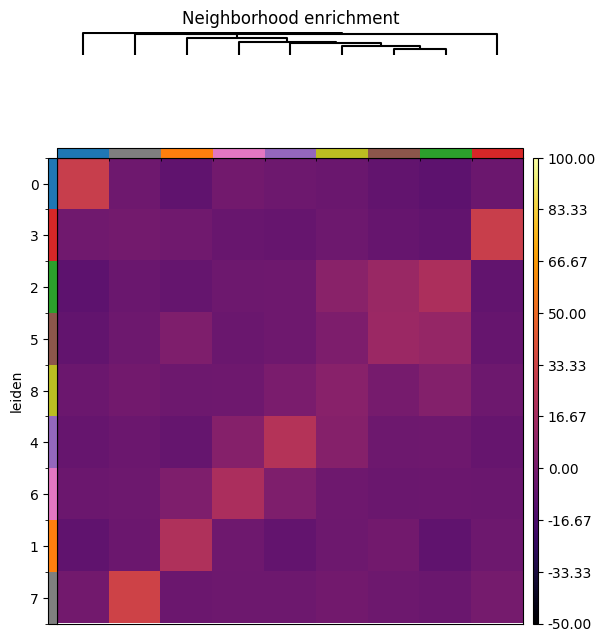

In [31]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(
    adata, cluster_key="leiden", method="single", cmap="inferno", vmin=-50, vmax=100
)
